# Tomato Leaf Classification

# Imports

In [77]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3

from sklearn.preprocessing import LabelEncoder



# Constants

In [4]:
PATH = "/Users/maukanmir/Downloads/archive/"
BATCH_SIZE=64
INPUT_SHAPE = (224,224,3)

train_path, val_path, test_path = PATH +"train/", PATH +"valid/", PATH +"test/"

# Functions

In [75]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size[:2])
      img = img.convert("RGB")
      
      img_arr = np.array(img)/255.0
      img_arr = img_arr.astype(np.float32)
      return img_arr
  except IOError as e:
    print(f"This Image was not able to be processed: {e}")
    return None

def grab_images(path, size=None):
  
  images, labels = [], []
  
  for root, dirs, files in os.walk(path):
    for file in files:
      if size and len(labels) == size:
        return np.array(images), np.array(labels)
      if file.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(root, file)
        img = load_process(img_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  return images, labels

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10,12))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def create_model(n_classes, input_shape=INPUT_SHAPE):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(356, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

def plot_images(images, labels, num_images=12, img_size=INPUT_SHAPE):
  
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  plt.figure(figsize=(10,10))
  
  for i in range(num_images):
    plt.subplot(3,4, i+1)
    idx = indices[i]
    img = images[idx].reshape(img_size)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")
  plt.show()
  
def plot_learning_curves(history):
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  
  epochs = range(1, len(acc)+1)
  
  plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc,"bo-",label="Training Accuracy")
  plt.plot(epochs, val_acc,"gs-", label="Validation Accuracy")
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(epochs, loss,"bo-" ,label="Training Loss")
  plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  
  plt.tight_layout()
  plt.show()
  

# Load Images

In [61]:
X_train, y_train = grab_images(train_path, 2000)
X_val, y_val = grab_images(val_path, 1000)
X_test, y_test = grab_images(test_path, 1000)

In [59]:
print(f"Training shape: {X_train.shape[0]}, {y_train.shape[0]}")
print(f"Validation shape: {X_val.shape[0]}, {y_val.shape[0]}")
print(f"Test shape: {X_test.shape[0]}, {y_test.shape[0]}")

Training shape: 2500, 2500
Validation shape: 2625, 2625
Test shape: 2625, 2625


# EDA Analysis

# Check Class Imabalance

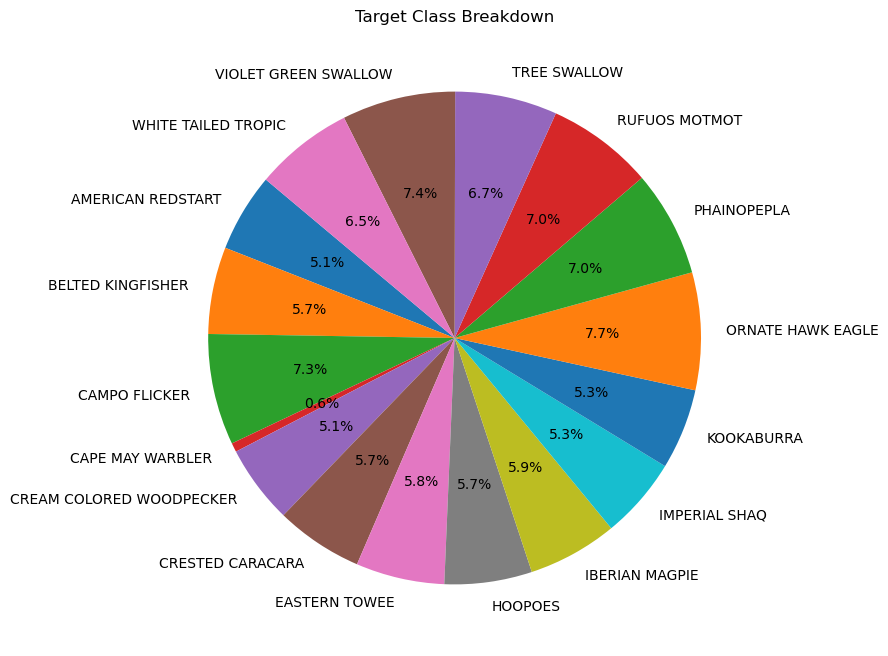

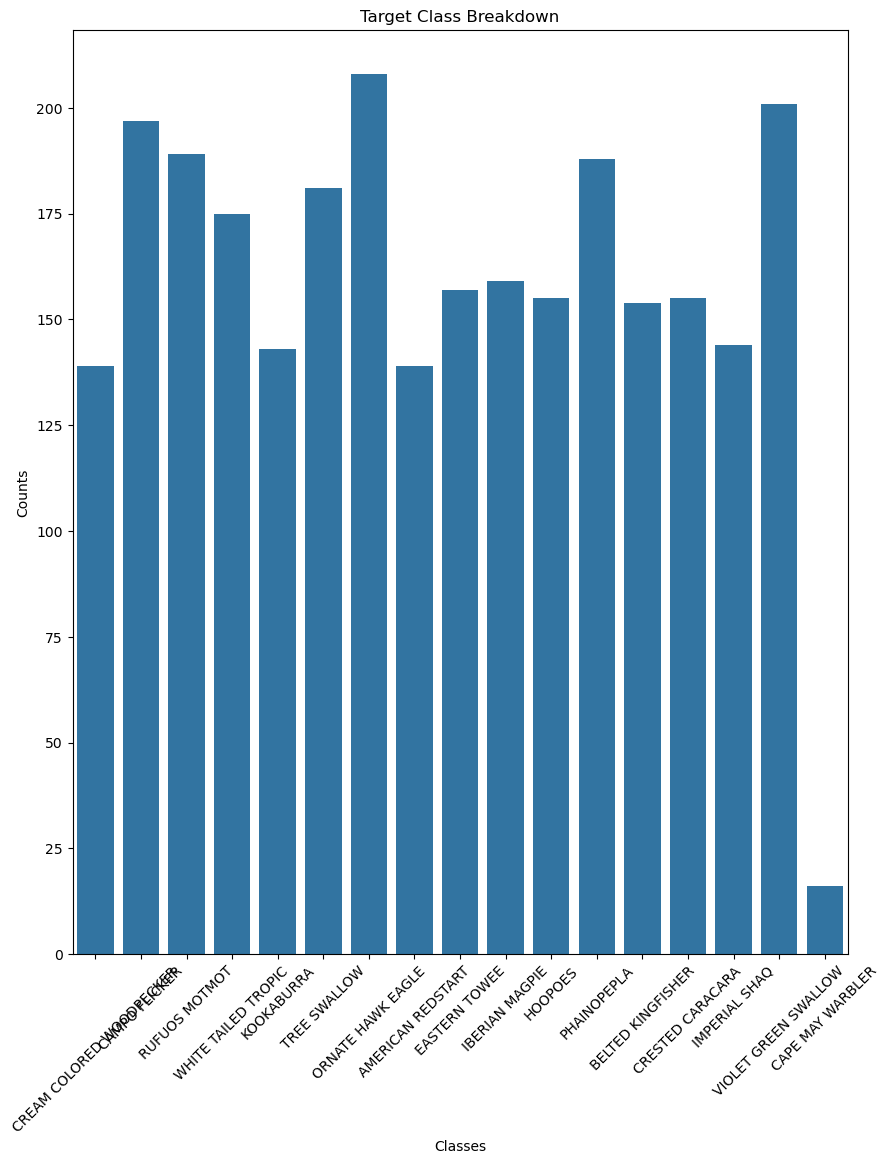

In [55]:
check_class_imbalance(y_train)

# Target class has some rare birds

# First look at our images

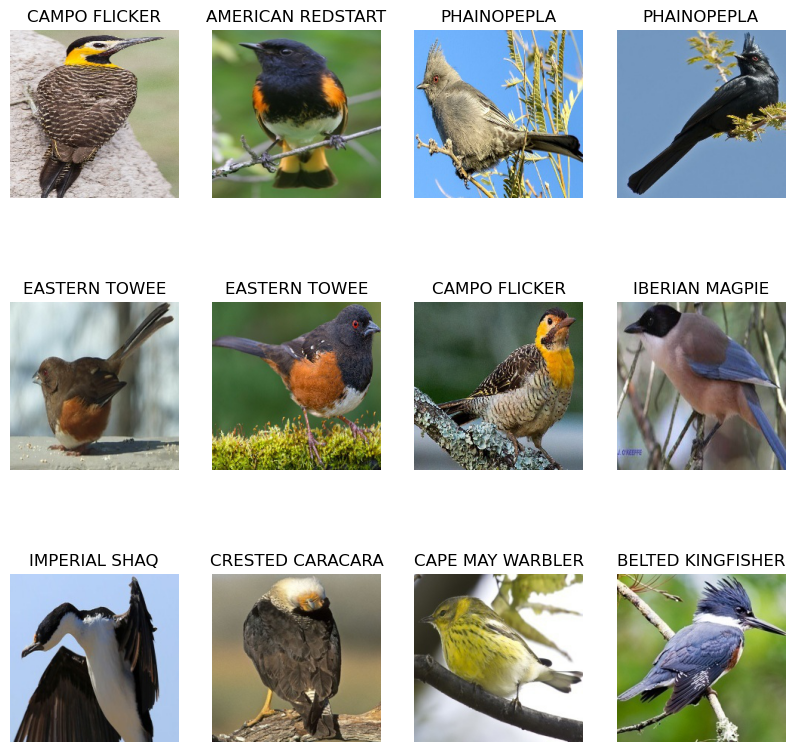

In [56]:
plot_images(X_train,y_train)

# Label encode and One hot encode target variables

In [63]:
class ExtendedLabelEncoder(LabelEncoder):
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.unknown_value = -1 
        super().__init__()
    
    def transform(self, y):
        try:
            return super().transform(y)
        except ValueError as e:
            if self.handle_unknown == 'ignore':
                return np.array([self.unknown_value if label not in self.classes_ else self.transform([label])[0] for label in y])
            else:
                raise e

encoder = ExtendedLabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)


y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

NUM_CLASSES = len(encoder.classes_)
one_hot_encoded_y_train = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_val = to_categorical(y_val_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_test = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

# We should incorporate data augmentation to ensure our model generalizes to unseen images

# Data Augmentation

In [64]:
train_datagen = ImageDataGenerator(
rotation_range=40,
horizontal_flip=True,
shear_range=0.2,
fill_mode="nearest"
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,
  one_hot_encoded_y_train,
  batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow(
  X_val,
  one_hot_encoded_y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test,
  one_hot_encoded_y_test,
  batch_size=BATCH_SIZE
)

# Create Model

In [65]:
model = create_model(NUM_CLASSES)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

# Early Stopping and Call Backs

In [66]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0.01,
  patience=15,
  verbose=0,
  mode="min",
  restore_best_weights=True
)

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_val.shape[0]//BATCH_SIZE
test_steps = X_test.shape[0]//BATCH_SIZE

# Fitting the model

In [67]:
history = model.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  epochs=100,
  validation_data=val_generator,
  validation_steps=validation_steps,
  callbacks=[early_stopping]
)

Epoch 1/100


2024-05-20 19:58:54.692547: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 19s 606ms/step - loss: 2.4748 - accuracy: 0.1209 - val_loss: 2.6142 - val_accuracy: 0.0448
Epoch 2/100
31/31 [==============================] - 19s 617ms/step - loss: 2.2995 - accuracy: 0.2014 - val_loss: 2.6431 - val_accuracy: 0.0812
Epoch 3/100
31/31 [==============================] - 19s 622ms/step - loss: 2.1003 - accuracy: 0.2934 - val_loss: 2.8287 - val_accuracy: 0.1604
Epoch 4/100
31/31 [==============================] - 20s 644ms/step - loss: 1.8758 - accuracy: 0.3621 - val_loss: 3.2520 - val_accuracy: 0.1010
Epoch 5/100
31/31 [==============================] - 20s 649ms/step - loss: 1.7551 - accuracy: 0.4013 - val_loss: 4.0309 - val_accuracy: 0.0875
Epoch 6/100
31/31 [==============================] - 20s 664ms/step - loss: 1.6279 - accuracy: 0.4437 - val_loss: 3.7638 - val_accuracy: 0.1521
Epoch 7/100
31/31 [==============================] - 21s 658ms/step - loss: 1.5286 - accuracy: 0.4607 - val_loss: 4.1630 - val_accuracy: 0.0729
Epoc

In [71]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print("Test Accuracy", test_acc)

15/15 [==============================] - 2s 134ms/step - loss: 2.6192 - accuracy: 0.0302
Test Accuracy 0.03020833246409893


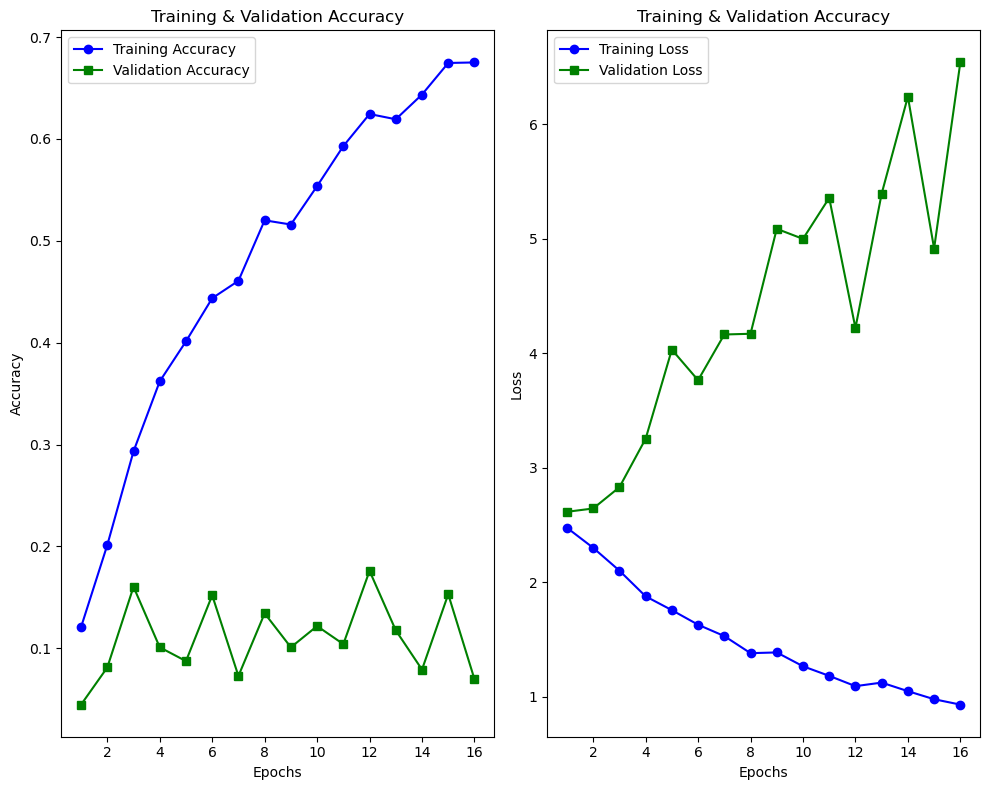

In [76]:
plot_learning_curves(history)

# Lets test the Inception Model

In [81]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers:
  layer.trainable = False

X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.2)(X)
prediction = Dense(NUM_CLASSES, activation="softmax")(X)

model_v3 = Model(inputs=base_model.input, outputs=prediction)

model_v3.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

history = model.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  epochs=100,
  validation_data=val_generator,
  validation_steps= validation_steps,
  callbacks=[early_stopping]
)

Epoch 1/100
31/31 [==============================] - 19s 621ms/step - loss: 2.2062 - accuracy: 0.2273 - val_loss: 3.5073 - val_accuracy: 0.0469
Epoch 2/100
31/31 [==============================] - 20s 645ms/step - loss: 2.0998 - accuracy: 0.2691 - val_loss: 3.5777 - val_accuracy: 0.0750
Epoch 3/100
31/31 [==============================] - 20s 644ms/step - loss: 1.8800 - accuracy: 0.3430 - val_loss: 3.1240 - val_accuracy: 0.1302
Epoch 4/100
31/31 [==============================] - 20s 650ms/step - loss: 1.7106 - accuracy: 0.4112 - val_loss: 4.5856 - val_accuracy: 0.1187
Epoch 5/100
31/31 [==============================] - 20s 653ms/step - loss: 1.5455 - accuracy: 0.4680 - val_loss: 4.1859 - val_accuracy: 0.1469
Epoch 6/100
31/31 [==============================] - 20s 651ms/step - loss: 1.3994 - accuracy: 0.5134 - val_loss: 6.0051 - val_accuracy: 0.0990
Epoch 7/100
31/31 [==============================] - 20s 647ms/step - loss: 1.3391 - accuracy: 0.5341 - val_loss: 4.6652 - val_accuracy:

In [82]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print("Test Accuracy", test_acc)

15/15 [==============================] - 2s 151ms/step - loss: 3.1898 - accuracy: 0.1187
Test Accuracy 0.11874999850988388
